In [86]:
import pandas as pd
df = pd.read_csv('../pitches.csv')

In [98]:
#drop unkown prediction classes and prediction classes with no definition from data source
df.drop_duplicates(inplace=True)
df = df[df.pitch_type != 'UN']
df = df[df.pitch_type != 'FA']
#convert negative break angles to positive angle measures
mask = df['break_angle'] < 0
df.break_angle.loc[mask] += 360
#drop data points where prediction class is unreliable
df = df[df.type_confidence >= 1.0]


In [99]:
df.head()

,ab_id,ax,ay,az,b_count,b_score,break_angle,break_length,break_y,code,end_speed,nasty,on_1b,on_2b,on_3b,outs,pfx_x,pfx_z,pitch_num,pitch_type,px,pz,s_count,spin_dir,spin_rate,start_speed,sz_bot,sz_top,type,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,zone
0,2.015000e+09,7.665,34.685,-11.960,0,0,335.0,3.2,23.7,C,84.1,55.0,False,False,False,0,4.16,10.93,1,FF,0.416,2.963,0,159.235,2305.052,92.9,1.72,3.56,S,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,3.0
1,2.015000e+09,12.043,34.225,-10.085,0,0,319.3,3.4,23.7,S,84.1,31.0,False,False,False,0,6.57,12.00,2,FF,-0.191,2.347,1,151.402,2689.935,92.8,1.72,3.56,S,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,5.0
2,2.015000e+09,14.368,35.276,-11.560,0,0,316.3,3.7,23.7,F,85.2,49.0,False,False,False,0,7.61,10.88,3,FF,-0.518,3.284,2,145.125,2647.972,94.1,1.72,3.56,S,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,1.0
3,2.015000e+09,2.104,28.354,-20.540,0,0,358.7,5.0,23.8,B,84.0,41.0,False,False,False,0,1.17,6.45,4,FF,-0.641,1.221,2,169.751,1289.590,91.0,1.74,3.35,B,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,13.0
4,2.015000e+09,-10.280,21.774,-34.111,1,0,18.4,12.0,23.8,B,69.6,18.0,False,False,False,0,-8.43,-1.65,5,CU,-1.821,2.083,2,280.671,1374.569,75.4,1.72,3.56,B,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,13.0


In [113]:
import numpy as np
desc = df[['break_angle', 'break_length', 'end_speed', 'pitch_type']].groupby('pitch_type').describe()
pd.options.display.max_columns = None
#remove wild pitches or intentional walks as break length outliers. Code sourced from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
df = df[np.abs(df.break_length-df.break_length.mean()) <= (3*df.break_length.std())]
desc = df[['break_angle', 'break_length', 'end_speed', 'pitch_type']].groupby('pitch_type').describe()
print("Break Angle")
display(desc['break_angle'])
print("Break Length")
display(desc['break_length'])
print("End Speed")
display(desc['end_speed'])

Break Angle


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,178328.0,129.974892,148.629401,0.0,20.900,28.10,331.200,359.9
CU,132758.0,254.276062,153.035035,-0.0,15.300,346.90,352.000,359.9
EP,132.0,190.576515,172.452670,1.2,7.400,345.00,351.875,359.9
FC,90885.0,240.353486,161.095917,-0.0,9.400,348.30,354.200,359.9
FF,609521.0,114.760663,139.756940,-0.0,21.800,33.70,319.100,359.9
FO,585.0,23.069915,20.658943,0.8,17.600,22.60,26.700,359.7
FS,26912.0,62.397406,110.826190,-0.0,14.400,20.50,27.300,359.9
FT,200244.0,108.984006,127.406077,-0.0,32.000,38.10,307.000,359.9
KC,41875.0,259.817318,151.751329,0.0,13.000,348.30,352.800,359.9


Break Length


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,178328.0,7.603777,1.321633,1.5,6.7,7.6,8.4,15.1
CU,132758.0,12.044088,1.714369,4.3,10.8,12.2,13.4,15.1
EP,132.0,13.376515,1.522245,9.1,12.4,13.7,14.7,15.1
FC,90885.0,5.821885,1.300343,0.7,5.0,5.9,6.7,12.9
FF,609521.0,3.960383,0.953485,0.1,3.3,3.9,4.5,14.8
FO,585.0,6.998120,1.270023,3.5,6.2,6.9,7.6,11.7
FS,26912.0,7.778627,1.296039,2.9,6.9,7.8,8.6,13.9
FT,200244.0,5.816370,0.999874,1.6,5.1,5.8,6.5,12.7
KC,41875.0,11.728530,1.574725,4.3,10.6,11.8,12.9,15.1


End Speed


,count,mean,std,min,25%,50%,75%,max
pitch_type,,,,,,,,
CH,178328.0,77.393588,3.248396,48.9,75.500,77.60,79.600,91.2
CU,132758.0,72.420089,3.353661,46.0,70.100,72.40,74.800,86.7
EP,132.0,62.879545,3.535615,54.0,60.100,62.70,65.525,71.3
FC,90885.0,81.774325,2.677696,59.8,80.100,81.80,83.500,92.2
FF,609521.0,85.221607,2.554841,55.9,83.600,85.30,86.900,96.5
FO,585.0,79.493333,2.168218,72.2,78.700,79.90,80.800,85.1
FS,26912.0,78.488808,2.708722,67.4,76.700,78.60,80.300,89.4
FT,200244.0,84.756474,2.473792,67.6,83.200,84.80,86.400,93.9
KC,41875.0,74.512377,2.921249,63.5,72.500,74.50,76.500,85.5


In [121]:
#separate pitches based on prediction class for visualization
four_seam_fast_ball = df[df.pitch_type == 'FF']
change_up = df[df.pitch_type == 'CH']
curve_ball = df[df.pitch_type == 'CB']
eephus = df[df.pitch_type == 'EP']
cutter = df[df.pitch_type == 'FC']
pitchout = df[df.pitch_type == 'FO']
splitter = df[df.pitch_type == 'FS']
two_seam_fastball = df[df.pitch_type == 'FT']
intentional_ball = df[df.pitch_type == 'IN']
knuckle_curve = df[df.pitch_type == 'KC']
knuckle_ball = df[df.pitch_type == 'KN']
screwball = df[df.pitch_type == 'SC']
sinker = df[df.pitch_type == 'SI']
slider = df[df.pitch_type == 'SL']


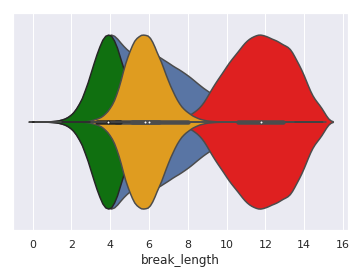

In [125]:
import seaborn as sns
%matplotlib inline
sns.set()
plt_data = df[['break_angle', 'break_length', 'end_speed']]
sns.violinplot(x=plt_data['break_length'])
sns.violinplot(x=knuckle_curve['break_length'], color='red')
sns.violinplot(x=four_seam_fast_ball['break_length'],color='green')
sns.violinplot(x=two_seam_fastball['break_length'], color='orange')